# New Summarization Agent 

The Intelligent News Synthesis System represents a breakthrough in automated news intelligence, leveraging cutting-edge multi-agent architecture to transform the way organizations and individuals consume news information. This sophisticated AI system orchestrates five specialized agents to deliver comprehensive, real-time news analysis from multiple premium sources.

In [15]:
from typing import Annotated, List, Dict, Optional
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langchain.agents import Tool
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
import requests
import json
import nest_asyncio
import asyncio
from datetime import datetime
import textwrap
import os

In [16]:
# Apply nest_asyncio for notebook compatibility
nest_asyncio.apply()

In [17]:
# ===== LOAD ENVIRONMENT =====
load_dotenv(override=True)

False

### State Definition 


#### User Input Layer

`query: str` - Original user search query


#### Query Processing

- `search_keywords: List[str]` - Extracted search terms (3-5 keywords)
- `news_sources: List[str]` - Target news sources for collection


#### Data Collection

- `raw_news_articles: List[Dict]` - Unprocessed articles from all sources
- `relevant_articles: List[Dict]` - Filtered articles matching query relevance
- `filtered_articles: List[Dict]` - Top-ranked articles for final processing


#### Output Generation

- `summary: str` - Synthesized content summary
- `final_report: str` - Professional formatted report


#### Workflow Control

- `has_news: bool` - Flag indicating if relevant news was found
- `processing_status: str` - Current workflow stage tracking
- `error_message: Optional[str]` - Error handling and logging


#### Agent Communication

- `messages: Annotated[list, add_messages]` - LLM conversation history with automatic message aggregation

In [18]:
class NewsState(TypedDict):
    """
    Comprehensive state for the news summarization workflow
    """
    # User input
    query: str
    
    # Processed query information
    search_keywords: List[str]
    news_sources: List[str]
    
    # Raw news data
    raw_news_articles: List[Dict]
    
    # Processed news data
    relevant_articles: List[Dict]
    filtered_articles: List[Dict]
    
    # Summary and report
    summary: str
    final_report: str
    
    # Workflow control
    has_news: bool
    processing_status: str
    error_message: Optional[str]
    
    # Messages for LLM communication
    messages: Annotated[list, add_messages]

### Configuration and Constants 

- Set up news urls 
- Init LLM
- Set up and extract browser tools 


In [19]:
# News source URLs
NEWS_SOURCES = {
    "bbc": "https://www.bbc.com/news",
    "cnn": "https://www.cnn.com",
    "reuters": "https://www.reuters.com",
    "guardian": "https://www.theguardian.com/world",
    "ap": "https://apnews.com"
}

In [20]:
# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini")

In [21]:
# Create browser tools
async_browser = create_async_playwright_browser(headless=True)
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
browser_tools = toolkit.get_tools()

# Extract specific tools
tool_dict = {tool.name: tool for tool in browser_tools}
navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

print("Browser tools initialized:")
for tool in browser_tools[:3]:  # Show first 3 tools
    print(f"- {tool.name}")


Browser tools initialized:
- click_element
- navigate_browser
- previous_webpage


### Agent Definitions 

#### Agent 1: Query Analyzer 🔍
**Responsibility:** Intelligent query parsing and keyword extraction

- NLP Processing: Advanced semantic analysis of user queries
- Keyword Extraction: Identifies 3-5 optimal search terms
- Intent Recognition: Categorizes query type (person, event, topic)
- Search Strategy: Optimizes search approach based on query complexity

#### Agent 2: News Collector 📡
**Responsibility:** Multi-source data acquisition

- Parallel Processing: Simultaneous collection from 5 major sources
- Content Extraction: Advanced web scraping with Playwright
- Data Validation: Ensures content quality and accessibility
- Timestamp Management: Tracks collection timing for freshness

#### Agent 3: Content Filter 🎯
**Responsibility:**  Relevance scoring and content curation

- Relevance Algorithm: Sophisticated scoring based on keyword density
- Quality Assessment: Filters out low-quality or irrelevant content
- Source Ranking: Prioritizes content from authoritative sources
- Duplicate Detection: Eliminates redundant information

#### Agent 4: Summary Generator 📝
**Responsibility:** Intelligent content synthesis

- Multi-document Summarization: Combines insights from multiple sources
- Perspective Analysis: Identifies different viewpoints on topics
- Fact Extraction: Highlights key developments and statistics
- Narrative Construction: Creates coherent, readable summaries

#### Agent 5: Report Writer 📊
**Responsibility:** Professional report generation

- Executive Summary: High-level overview for decision makers
- Detailed Analysis: Comprehensive breakdown of findings
- Source Attribution: Proper citation and credibility tracking
- Format Optimization: Professional presentation for business use

## Detailed Agent Definitions

### Agent 1: Query Analyzer 


**Function Summary**
- Purpose: First agent in pipeline - intelligently parses user queries into structured search parameters

**Core Functionality:**

`Query Processing`

- Takes raw user query from state['query']
- Uses GPT-4 for advanced semantic analysis
- Identifies query intent (person, event, or topic)


`Keyword Extraction`

- Extracts 3-5 optimal search keywords
- Uses NLP to identify most relevant terms
- Formats as comma-separated list for downstream agents


`LLM Integration`

- Constructs system prompt with specific instructions
- Invokes OpenAI model for intelligent analysis
- Parses response to extract structured keywords


`State Management`

- Updates search_keywords with extracted terms
- Sets news_sources to all available sources (BBC, CNN, Reuters, Guardian, AP)
- Updates processing_status to "query_analyzed"
- Appends confirmation message to conversation history


`Output Processing`

- Simple string parsing to extract keywords from LLM response
- Handles case-insensitive keyword detection
- Strips whitespace and formats for next agent



In [22]:
def query_analyzer_agent(state: NewsState) -> NewsState:
    """
    Agent 1: Analyzes user query and extracts search parameters
    """
    system_prompt = f"""
    You are a query analyzer for news search. 
    Analyze this query: "{state['query']}"
    
    Extract and return ONLY:
    1. 3-5 main search keywords (comma-separated)
    2. Determine if this is about a specific person, event, or topic
    
    Format: keywords: word1, word2, word3
    """
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": state["query"]}
    ]
    
    response = llm.invoke(messages)
    content = response.content
    
    # Extract keywords (simplified parsing)
    keywords = []
    if "keywords:" in content.lower():
        keyword_part = content.lower().split("keywords:")[1].split("\n")[0]
        keywords = [k.strip() for k in keyword_part.split(",")]
    
    return {
        **state,
        "search_keywords": keywords,
        "news_sources": list(NEWS_SOURCES.keys()),
        "processing_status": "query_analyzed",
        "messages": state["messages"] + [{"role": "assistant", "content": f"Analyzed query. Keywords: {', '.join(keywords)}"}]
    }


### Agent 2 News Collector Agent

**Function Summary**
Purpose: Second agent in pipeline - performs parallel web scraping to collect raw news content from multiple sources

**Core Functionality:**

`Multi-Source Collection`

- Iterates through predefined news sources (BBC, CNN, Reuters, Guardian, AP)
- Limited to 2 sources in demo to prevent timeouts
- Processes sources sequentially with async operations


`Web Automation`

- Uses Playwright browser tools for robust web scraping
- navigate_tool.arun() - navigates to each news source URL
- extract_text_tool.arun() - extracts all text content from pages


`Content Processing`

- Truncates content to 3000 characters max for processing efficiency
- Preserves full content structure while managing memory usage
- Timestamps each collection for freshness tracking


`Data Structuring`

Creates structured article objects with:

- source: News outlet name
- url: Source website URL
- content: Extracted/truncated text content
- timestamp: ISO format collection time


`Error Handling`

- Try-catch blocks for each source to prevent pipeline failure
- Logs errors with detailed source information
- Creates error objects preserving source metadata
- Continues processing remaining sources despite individual failures


`State Management`

- Updates raw_news_articles with collected content array
- Sets processing_status to "news_collected"
- Appends collection summary to conversation messages
- Preserves all existing state data


In [23]:
async def news_collector_agent(state: NewsState) -> NewsState:
    """
    Agent 2: Collects news from multiple sources
    """
    raw_articles = []
    
    # For demo, collect from 2 sources to avoid timeout
    sources_to_check = list(NEWS_SOURCES.items())[:2]
    
    for source_name, source_url in sources_to_check:
        try:
            print(f"Collecting from {source_name}...")
            
            # Navigate to news source
            await navigate_tool.arun({"url": source_url})
            
            # Extract text content
            content = await extract_text_tool.arun({})
            
            # Truncate content for processing
            truncated_content = content[:3000] if len(content) > 3000 else content
            
            raw_articles.append({
                "source": source_name,
                "url": source_url,
                "content": truncated_content,
                "timestamp": datetime.now().isoformat()
            })
            
        except Exception as e:
            print(f"Error collecting from {source_name}: {str(e)}")
            raw_articles.append({
                "source": source_name,
                "url": source_url,
                "error": str(e),
                "timestamp": datetime.now().isoformat()
            })
    
    return {
        **state,
        "raw_news_articles": raw_articles,
        "processing_status": "news_collected",
        "messages": state["messages"] + [{"role": "assistant", "content": f"Collected news from {len(raw_articles)} sources"}]
    }

### Agent 3 : Content Filter 

Purpose: Third agent in pipeline - analyzes and ranks collected articles based on query relevance using keyword scoring

**Core Functionality:**

`Input Processing`

- Retrieves search_keywords from Query Analyzer Agent
- Processes raw_news_articles from News Collector Agent
- Skips articles with collection errors automatically

`Relevance Scoring Algorithm`

- Keyword Matching: Searches for each keyword in article content
- Frequency Counting: Counts occurrences of each keyword in content
- Cumulative Scoring: Adds keyword counts for total relevance score
- Case-Insensitive: Converts content to lowercase for robust matching


`Content Filtering`

- Only processes articles without collection errors
- Requires relevance score > 0 to be considered relevant
- Adds relevance_score field to qualifying articles
- Excludes articles with zero keyword matches


`Ranking & Selection`

- Sorts relevant articles by relevance score (highest first)
- Selects top 5 articles for final processing (filtered_articles)
- Maintains full relevant articles list for reference


`News Availability Detection`

- Sets has_news boolean flag based on relevant articles found
- Enables downstream agents to handle "no news" scenarios
- Critical for workflow branching logic


`State Management`

- Updates relevant_articles with all scored articles
- Updates filtered_articles with top 5 selections
- Updates has_news flag for workflow control
- Sets processing_status to "news_filtered"
- Appends summary message with article count

In [24]:
def news_filter_agent(state: NewsState) -> NewsState:
    """
    Agent 3: Filters and ranks news articles based on relevance
    """
    keywords = state["search_keywords"]
    raw_articles = state["raw_news_articles"]
    
    relevant_articles = []
    
    for article in raw_articles:
        if "error" in article:
            continue
            
        content = article["content"].lower()
        
        # Simple relevance scoring
        relevance_score = 0
        for keyword in keywords:
            if keyword.lower() in content:
                relevance_score += content.count(keyword.lower())
        
        if relevance_score > 0:
            article["relevance_score"] = relevance_score
            relevant_articles.append(article)
    
    # Sort by relevance
    relevant_articles.sort(key=lambda x: x["relevance_score"], reverse=True)
    
    has_news = len(relevant_articles) > 0
    
    return {
        **state,
        "relevant_articles": relevant_articles,
        "filtered_articles": relevant_articles[:5],  # Top 5
        "has_news": has_news,
        "processing_status": "news_filtered",
        "messages": state["messages"] + [{"role": "assistant", "content": f"Found {len(relevant_articles)} relevant articles"}]
    }


Agent 4 -  Summary Agent 

Purpose: Fourth agent in pipeline - synthesizes filtered articles into comprehensive, structured news summary

**Core Functionality:**

`Conditional Processing`

- Checks has_news flag from Filter Agent
- Returns "no news" message if no relevant articles found
- Sets status to "no_news_to_summarize" for workflow branching


`Content Preparation`

- Processes top 3 articles from filtered_articles (highest relevance)
- Truncates each article to 800 characters to manage context limits
- Formats with source attribution headers for clarity
- Concatenates into single text block for LLM processing


`LLM Integration`

- Uses GPT-4 for intelligent multi-document summarization
- Provides structured system prompt with specific instructions
- Includes original user query for context-aware summarization


`Summary Structure Requirements`

- Main Headlines: Key points and breaking developments
- Key Facts: Important statistics and concrete information
- Different Perspectives: Multiple viewpoints when available
- Objective Tone: Factual, unbiased presentation
- Concise Format: Informative but not verbose


`Content Optimization`

- Limits to 3 articles to prevent context overflow
- 800-character limit per article for token efficiency
- Preserves source attribution for credibility
- Maintains query context throughout summarization


`State Management`

- Updates summary with generated content
- Sets processing_status to "news_summarized"
- Appends confirmation message to conversation history
- Preserves all existing state data

In [25]:
def summary_agent(state: NewsState) -> NewsState:
    """
    Agent 4: Summarizes filtered news articles
    """
    if not state["has_news"]:
        return {
            **state,
            "summary": "No relevant news articles found for the given query.",
            "processing_status": "no_news_to_summarize"
        }
    
    # Prepare content for summarization
    articles_content = ""
    for i, article in enumerate(state["filtered_articles"][:3]):  # Top 3 articles
        articles_content += f"\n--- Article {i+1} from {article['source']} ---\n"
        articles_content += article["content"][:800]  # Truncate for context limits
        articles_content += "\n"
    
    system_prompt = f"""
    You are a news summarization agent. Create a comprehensive summary of the provided news articles 
    related to the query: "{state['query']}"
    
    Structure your summary with:
    1. Main headlines and key points
    2. Key facts and developments
    3. Different perspectives if available
    
    Be objective and factual. Keep it concise but informative.
    """
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Articles to summarize:\n{articles_content}"}
    ]
    
    response = llm.invoke(messages)
    summary = response.content
    
    return {
        **state,
        "summary": summary,
        "processing_status": "news_summarized",
        "messages": state["messages"] + [{"role": "assistant", "content": "Created news summary"}]
    }

### Agent 5 : Report Writer Agent 



**Primary Function:**

- Generates final formatted HTML reports suitable for A4 printing based on news analysis results

- Handles Two Scenarios: Creates comprehensive reports when news is found, or "no results" reports when no relevant articles are discovered
- Output Format: Professional HTML documents optimized for both screen viewing and printing

**Key Support Functions**

`HTML Report Generation`

- generate_comprehensive_html_report(): Creates detailed reports with news analysis, charts, and professional formatting
- generate_no_news_html_report(): Generates informative reports when no relevant news articles are found
- Uses GPT-4o-mini: Leverages LLM for content generation and professional report writing

`Styling & Formatting`

- get_report_css(): Provides comprehensive CSS styling optimized for A4 printing with responsive design
- format_report_content(): Converts markdown-style content to properly formatted HTML
- Print Optimization: Includes specific CSS rules for clean printing and page breaks

`Data Visualization`

- generate_relevance_chart_data(): Creates data structures for source distribution charts
- generate_chart_script(): Generates Chart.js code for interactive doughnut charts
- Visual Metrics: Displays key statistics like article counts, source diversity, and relevance scores

`Content Organization`

- generate_source_cards(): Creates visual cards showing article distribution by news source
- generate_keyword_tags(): Formats search keywords as visual tags
- Methodology Section: Documents the AI analysis process and search parameters

`Report Features`

- Executive Summary: AI-generated professional summary of findings
- Key Metrics Dashboard: Visual display of analysis statistics
- Source Distribution Chart: Interactive visualization of article sources
- Methodology Documentation: Transparent explanation of the analysis process
- Professional Footer: Timestamps and system identification

`File Management`

- save_html_report(): Saves generated HTML reports to files with timestamped names
- Error Handling: Includes try-catch blocks for file operations and content generation

The agent creates publication-ready reports that combine AI analysis with professional presentation suitable for business or research use




In [26]:
def report_writer_agent(state: NewsState) -> NewsState:
    """
    Agent 5: Generates final formatted HTML report suitable for A4 printing
    """
    if not state["has_news"]:
        # Generate no-news HTML report
        no_news_html = generate_no_news_html_report(state)
        return {
            **state,
            "final_report": no_news_html,
            "processing_status": "report_completed"
        }
    
    # Generate comprehensive HTML report
    html_report = generate_comprehensive_html_report(state)
    
    return {
        **state,
        "final_report": html_report,
        "processing_status": "report_completed",
        "messages": state["messages"] + [{"role": "assistant", "content": "Professional HTML report generated"}]
    }

def generate_no_news_html_report(state: NewsState) -> str:
    """Generate HTML report when no news is found"""
    
    current_time = datetime.now()
    
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>News Analysis Report - No Results</title>
        <style>
            {get_report_css()}
        </style>
    </head>
    <body>
        <div class="container">
            <header class="report-header">
                <h1>AI News Intelligence Report</h1>
                <div class="report-meta">
                    <div class="meta-item">
                        <strong>Query:</strong> {state['query']}
                    </div>
                    <div class="meta-item">
                        <strong>Generated:</strong> {current_time.strftime('%B %d, %Y at %I:%M %p')}
                    </div>
                    <div class="meta-item">
                        <strong>Status:</strong> <span class="status-no-results">No Results Found</span>
                    </div>
                </div>
            </header>

            <section class="executive-summary">
                <h2>Executive Summary</h2>
                <div class="summary-content">
                    <p>Our comprehensive search across major international news sources including BBC, CNN, Reuters, The Guardian, and AP News found no relevant articles matching your specified query criteria.</p>
                </div>
            </section>

            <section class="search-details">
                <h2>Search Analysis</h2>
                <div class="details-grid">
                    <div class="detail-card">
                        <h3>Search Parameters</h3>
                        <ul>
                            <li><strong>Keywords:</strong> {', '.join(state.get('search_keywords', []))}</li>
                            <li><strong>Sources:</strong> {', '.join(state.get('news_sources', []))}</li>
                            <li><strong>Timestamp:</strong> {current_time.isoformat()}</li>
                        </ul>
                    </div>
                </div>
            </section>

            <section class="recommendations">
                <h2>Recommendations</h2>
                <div class="recommendation-content">
                    <h3>Possible Reasons for No Results:</h3>
                    <ul>
                        <li>The topic may not be currently in the news cycle</li>
                        <li>Search terms may need refinement or alternative keywords</li>
                        <li>The news may be region-specific or from specialized sources</li>
                        <li>The topic might be too recent or too specific</li>
                    </ul>
                    
                    <h3>Suggested Actions:</h3>
                    <ul>
                        <li>Try broader or alternative search terms</li>
                        <li>Check for spelling variations or synonyms</li>
                        <li>Consider searching for related topics</li>
                        <li>Try again later as news cycles change rapidly</li>
                    </ul>
                </div>
            </section>

            <footer class="report-footer">
                <p>Report generated by AI News Summarizer Agent | Powered by Multi-Agent Architecture</p>
                <p class="timestamp">Generated on {current_time.strftime('%Y-%m-%d %H:%M:%S UTC')}</p>
            </footer>
        </div>
    </body>
    </html>
    """
    
    return html_content

def generate_comprehensive_html_report(state: NewsState) -> str:
    """Generate comprehensive HTML report with news results"""
    
    # Use GPT-4 for content generation
    system_prompt = f"""
    You are a professional report writer. Create detailed content for a news analysis report based on the summary provided.
    
    The report should include:
    1. Executive Summary (2-3 paragraphs)
    2. Key Headlines (bullet points of main stories)
    3. Detailed Analysis (comprehensive breakdown)
    4. Market/Industry Impact (if applicable)
    5. Key Takeaways (actionable insights)
    
    Make it professional, well-structured, and informative. Focus on facts and avoid speculation.
    """
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Create comprehensive report content for query: '{state['query']}'\\n\\nSummary: {state['summary']}\\n\\nSources: {', '.join([a['source'] for a in state['filtered_articles']])}"}
    ]
    
    # Get LLM response
    llm = ChatOpenAI(model="gpt-4o-mini")
    response = llm.invoke(messages)
    report_content = response.content
    
    current_time = datetime.now()
    article_count = len(state['relevant_articles'])
    source_list = list(set([article['source'].upper() for article in state['filtered_articles']]))
    
    # Generate relevance chart data
    relevance_data = generate_relevance_chart_data(state['filtered_articles'])
    
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>News Analysis Report - {state['query']}</title>
        <style>
            {get_report_css()}
        </style>
        <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
    </head>
    <body>
        <div class="container">
            <header class="report-header">
                <h1>AI News Intelligence Report</h1>
                <div class="report-meta">
                    <div class="meta-item">
                        <strong>Query:</strong> {state['query']}
                    </div>
                    <div class="meta-item">
                        <strong>Generated:</strong> {current_time.strftime('%B %d, %Y at %I:%M %p')}
                    </div>
                    <div class="meta-item">
                        <strong>Articles Analyzed:</strong> <span class="highlight">{article_count}</span>
                    </div>
                    <div class="meta-item">
                        <strong>Status:</strong> <span class="status-success">Analysis Complete</span>
                    </div>
                </div>
            </header>

            <section class="key-metrics">
                <h2>Analysis Overview</h2>
                <div class="metrics-grid">
                    <div class="metric-card">
                        <div class="metric-value">{len(state['search_keywords'])}</div>
                        <div class="metric-label">Keywords Analyzed</div>
                    </div>
                    <div class="metric-card">
                        <div class="metric-value">{len(state['news_sources'])}</div>
                        <div class="metric-label">Sources Searched</div>
                    </div>
                    <div class="metric-card">
                        <div class="metric-value">{article_count}</div>
                        <div class="metric-label">Relevant Articles</div>
                    </div>
                    <div class="metric-card">
                        <div class="metric-value">{len(source_list)}</div>
                        <div class="metric-label">Active Sources</div>
                    </div>
                </div>
            </section>

            <section class="chart-section">
                <h2>Source Distribution</h2>
                <div class="chart-container">
                    <canvas id="sourceChart" width="400" height="200"></canvas>
                </div>
            </section>

            <section class="report-content">
                <div class="content-formatted">
                    {format_report_content(report_content)}
                </div>
            </section>

            <section class="sources-section">
                <h2>Sources Referenced</h2>
                <div class="sources-grid">
                    {generate_source_cards(state['filtered_articles'])}
                </div>
            </section>

            <section class="methodology">
                <h2>Methodology</h2>
                <div class="methodology-content">
                    <h3>Data Collection Process</h3>
                    <ol>
                        <li><strong>Query Analysis:</strong> Advanced NLP processing to extract optimal search keywords</li>
                        <li><strong>Multi-Source Collection:</strong> Parallel data retrieval from {len(state['news_sources'])} major news outlets</li>
                        <li><strong>Relevance Filtering:</strong> AI-powered content scoring based on keyword density and context</li>
                        <li><strong>Content Synthesis:</strong> Multi-document summarization with perspective analysis</li>
                        <li><strong>Report Generation:</strong> Professional formatting with executive-level insights</li>
                    </ol>
                    
                    <h3>Search Keywords</h3>
                    <div class="keywords-list">
                        {generate_keyword_tags(state['search_keywords'])}
                    </div>
                </div>
            </section>

            <footer class="report-footer">
                <div class="footer-content">
                    <div class="footer-left">
                        <p><strong>AI News Summarizer Agent</strong></p>
                        <p>Powered by Multi-Agent Architecture</p>
                    </div>
                    <div class="footer-right">
                        <p>Generated: {current_time.strftime('%Y-%m-%d %H:%M:%S UTC')}</p>
                        <p>Thread ID: {current_time.strftime('%Y%m%d_%H%M%S')}</p>
                    </div>
                </div>
            </footer>
        </div>

        <script>
            {generate_chart_script(relevance_data)}
        </script>
    </body>
    </html>
    """
    
    return html_content

def get_report_css() -> str:
    """Generate CSS styles optimized for A4 printing"""
    return """
        @page {
            size: A4;
            margin: 2cm 1.5cm;
        }
        
        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }
        
        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            line-height: 1.6;
            color: #333;
            background-color: #fff;
        }
        
        .container {
            max-width: 210mm;
            margin: 0 auto;
            padding: 20px;
        }
        
        .report-header {
            text-align: center;
            border-bottom: 3px solid #2c3e50;
            padding-bottom: 20px;
            margin-bottom: 30px;
        }
        
        .report-header h1 {
            font-size: 2.5em;
            color: #2c3e50;
            margin-bottom: 15px;
            font-weight: 300;
        }
        
        .report-meta {
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 10px;
            margin-top: 15px;
        }
        
        .meta-item {
            padding: 8px 15px;
            background: #f8f9fa;
            border-radius: 5px;
            font-size: 0.9em;
        }
        
        .status-success {
            color: #27ae60;
            font-weight: bold;
        }
        
        .status-no-results {
            color: #e74c3c;
            font-weight: bold;
        }
        
        .highlight {
            color: #3498db;
            font-weight: bold;
        }
        
        h2 {
            color: #2c3e50;
            border-bottom: 2px solid #ecf0f1;
            padding-bottom: 5px;
            margin: 25px 0 15px 0;
            font-size: 1.5em;
        }
        
        h3 {
            color: #34495e;
            margin: 20px 0 10px 0;
            font-size: 1.2em;
        }
        
        .key-metrics {
            margin: 30px 0;
        }
        
        .metrics-grid {
            display: grid;
            grid-template-columns: repeat(4, 1fr);
            gap: 15px;
            margin: 20px 0;
        }
        
        .metric-card {
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 20px;
            border-radius: 8px;
            text-align: center;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
        }
        
        .metric-value {
            font-size: 2em;
            font-weight: bold;
            margin-bottom: 5px;
        }
        
        .metric-label {
            font-size: 0.9em;
            opacity: 0.9;
        }
        
        .chart-section {
            margin: 30px 0;
            padding: 20px;
            background: #f8f9fa;
            border-radius: 8px;
        }
        
        .chart-container {
            max-width: 600px;
            margin: 0 auto;
        }
        
        .executive-summary,
        .report-content {
            margin: 25px 0;
        }
        
        .summary-content,
        .content-formatted {
            background: #fdfdfd;
            padding: 20px;
            border-left: 4px solid #3498db;
            border-radius: 0 5px 5px 0;
        }
        
        .content-formatted h3 {
            color: #2c3e50;
            margin-top: 25px;
        }
        
        .content-formatted ul,
        .content-formatted ol {
            margin: 10px 0 10px 20px;
        }
        
        .content-formatted li {
            margin: 5px 0;
        }
        
        .sources-section {
            margin: 30px 0;
        }
        
        .sources-grid {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 15px;
            margin: 20px 0;
        }
        
        .source-card {
            background: #fff;
            border: 1px solid #e1e8ed;
            border-radius: 8px;
            padding: 15px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }
        
        .source-name {
            font-weight: bold;
            color: #2c3e50;
            margin-bottom: 8px;
        }
        
        .source-relevance {
            font-size: 0.9em;
            color: #7f8c8d;
        }
        
        .relevance-bar {
            width: 100%;
            height: 6px;
            background: #ecf0f1;
            border-radius: 3px;
            margin: 5px 0;
            overflow: hidden;
        }
        
        .relevance-fill {
            height: 100%;
            background: linear-gradient(90deg, #27ae60, #2ecc71);
            transition: width 0.3s ease;
        }
        
        .methodology {
            margin: 30px 0;
            background: #f8f9fa;
            padding: 20px;
            border-radius: 8px;
        }
        
        .methodology ol {
            margin: 15px 0 15px 20px;
        }
        
        .methodology li {
            margin: 8px 0;
            padding-left: 10px;
        }
        
        .keywords-list {
            display: flex;
            flex-wrap: wrap;
            gap: 8px;
            margin: 15px 0;
        }
        
        .keyword-tag {
            background: #3498db;
            color: white;
            padding: 5px 12px;
            border-radius: 20px;
            font-size: 0.85em;
            font-weight: 500;
        }
        
        .details-grid {
            display: grid;
            grid-template-columns: 1fr;
            gap: 20px;
            margin: 20px 0;
        }
        
        .detail-card {
            background: #fff;
            border: 1px solid #e1e8ed;
            border-radius: 8px;
            padding: 20px;
        }
        
        .recommendations {
            margin: 30px 0;
        }
        
        .recommendation-content {
            background: #fff3cd;
            border: 1px solid #ffeeba;
            border-radius: 8px;
            padding: 20px;
        }
        
        .recommendation-content h3 {
            color: #856404;
            margin-bottom: 10px;
        }
        
        .recommendation-content ul {
            margin: 10px 0 20px 20px;
        }
        
        .recommendation-content li {
            margin: 5px 0;
            color: #6c5600;
        }
        
        .report-footer {
            margin-top: 40px;
            padding-top: 20px;
            border-top: 2px solid #ecf0f1;
            font-size: 0.9em;
            color: #7f8c8d;
        }
        
        .footer-content {
            display: flex;
            justify-content: space-between;
            align-items: center;
        }
        
        .footer-left p {
            margin: 2px 0;
        }
        
        .footer-right {
            text-align: right;
        }
        
        .footer-right p {
            margin: 2px 0;
        }
        
        .timestamp {
            font-style: italic;
            font-size: 0.8em;
        }
        
        /* Print optimizations */
        @media print {
            .container {
                margin: 0;
                padding: 0;
            }
            
            .chart-section {
                break-inside: avoid;
            }
            
            .metric-card {
                break-inside: avoid;
            }
            
            .source-card {
                break-inside: avoid;
            }
            
            h2 {
                break-after: avoid;
            }
            
            .page-break {
                page-break-before: always;
            }
        }
        
        /* Responsive design */
        @media (max-width: 768px) {
            .metrics-grid {
                grid-template-columns: repeat(2, 1fr);
            }
            
            .report-meta {
                grid-template-columns: 1fr;
            }
            
            .footer-content {
                flex-direction: column;
                text-align: center;
                gap: 10px;
            }
        }
    """

def format_report_content(content: str) -> str:
    """Format the LLM-generated content for HTML display"""
    # Convert markdown-style formatting to HTML
    content = content.replace('**', '<strong>').replace('**', '</strong>')
    content = content.replace('# ', '<h3>').replace('\n', '</h3>\n', 1)
    
    # Convert bullet points
    lines = content.split('\n')
    formatted_lines = []
    in_list = False
    
    for line in lines:
        line = line.strip()
        if line.startswith('- ') or line.startswith('• '):
            if not in_list:
                formatted_lines.append('<ul>')
                in_list = True
            formatted_lines.append(f'<li>{line[2:].strip()}</li>')
        else:
            if in_list:
                formatted_lines.append('</ul>')
                in_list = False
            if line:
                if not line.startswith('<'):
                    formatted_lines.append(f'<p>{line}</p>')
                else:
                    formatted_lines.append(line)
    
    if in_list:
        formatted_lines.append('</ul>')
    
    return '\n'.join(formatted_lines)

def generate_source_cards(articles: list) -> str:
    """Generate HTML cards for each source"""
    source_data = {}
    
    # Aggregate data by source
    for article in articles:
        source = article['source'].upper()
        if source not in source_data:
            source_data[source] = {
                'count': 0,
                'total_relevance': 0
            }
        source_data[source]['count'] += 1
        source_data[source]['total_relevance'] += article.get('relevance_score', 0)
    
    cards_html = ""
    for source, data in source_data.items():
        avg_relevance = data['total_relevance'] / data['count'] if data['count'] > 0 else 0
        relevance_width = min(100, (avg_relevance / 10) * 100)  # Assuming max relevance of 10
        
        cards_html += f"""
        <div class="source-card">
            <div class="source-name">{source}</div>
            <div class="source-relevance">Articles: {data['count']} | Avg. Relevance: {avg_relevance:.1f}</div>
            <div class="relevance-bar">
                <div class="relevance-fill" style="width: {relevance_width}%"></div>
            </div>
        </div>
        """
    
    return cards_html

def generate_keyword_tags(keywords: list) -> str:
    """Generate HTML tags for keywords"""
    tags_html = ""
    for keyword in keywords:
        tags_html += f'<span class="keyword-tag">{keyword}</span>'
    return tags_html

def generate_relevance_chart_data(articles: list) -> dict:
    """Generate data for the source distribution chart"""
    source_counts = {}
    for article in articles:
        source = article['source'].upper()
        source_counts[source] = source_counts.get(source, 0) + 1
    
    return {
        'labels': list(source_counts.keys()),
        'data': list(source_counts.values())
    }

def generate_chart_script(chart_data: dict) -> str:
    """Generate JavaScript for Chart.js visualization"""
    return f"""
        document.addEventListener('DOMContentLoaded', function() {{
            const ctx = document.getElementById('sourceChart').getContext('2d');
            new Chart(ctx, {{
                type: 'doughnut',
                data: {{
                    labels: {chart_data['labels']},
                    datasets: [{{
                        data: {chart_data['data']},
                        backgroundColor: [
                            '#3498db',
                            '#e74c3c',
                            '#2ecc71',
                            '#f39c12',
                            '#9b59b6',
                            '#1abc9c'
                        ],
                        borderWidth: 2,
                        borderColor: '#fff'
                    }}]
                }},
                options: {{
                    responsive: true,
                    maintainAspectRatio: false,
                    plugins: {{
                        legend: {{
                            position: 'bottom',
                            labels: {{
                                padding: 20,
                                usePointStyle: true
                            }}
                        }},
                        title: {{
                            display: true,
                            text: 'Article Distribution by Source'
                        }}
                    }}
                }}
            }});
        }});
    """

# Additional helper function to save HTML report to file
def save_html_report(html_content: str, filename: str = None) -> str:
    """Save HTML report to file and return the filename"""
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"news_report_{timestamp}.html"
    
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(html_content)
        return filename
    except Exception as e:
        print(f"Error saving HTML report: {str(e)}")
        return None

### Conditional Edge Function - Summary


Purpose: Workflow control function that determines the next step in the news processing pipeline

**Core Functionality:**

`Decision Logic`

- Evaluates has_news boolean flag from News Filter Agent
- Returns string identifiers for LangGraph routing decisions


`Routing Options`

- "summarize": Directs workflow to Summary Agent when relevant news found
- "report_no_news": Bypasses summarization, goes directly to Report Writer Agent


Workflow Branching

Enables conditional execution based on content availability
Prevents unnecessary processing when no relevant articles exist
Optimizes pipeline efficiency by skipping summarization step


Integration with LangGraph

Used in add_conditional_edges() for graph workflow control
Return values map to specific agent nodes in the workflow
Enables dynamic path selection based on processing results





In [27]:

def should_continue_to_summary(state: NewsState) -> str:
    """Conditional edge: Determine if we should summarize or go to no-news report"""
    if state["has_news"]:
        return "summarize"
    else:
        return "report_no_news"

### Build Workflow Graph 

Purpose: Constructs the complete LangGraph workflow orchestrating all five news processing agents

**Core Functionality:**

`Graph Initialization`

- Creates StateGraph instance with NewsState type definition
- Establishes state management framework for multi-agent coordination

`Node Registration`

- "analyze_query": Maps to Query Analyzer Agent
- "collect_news": Maps to News Collector Agent
- "filter_news": Maps to News Filter Agent
- "summarize_news": Maps to Summary Agent
- "generate_report": Maps to Report Writer Agent


`Linear Workflow Edges`

- START → "analyze_query": Entry point for user queries
- "analyze_query" → "collect_news": Sequential processing flow
- "collect_news" → "filter_news": Continues linear progression


`Conditional Branching Logic`

- Source: "filter_news" node
- Decision Function: should_continue_to_summary
- Routes:
  - "summarize" → "summarize_news" (when news found)
  - "report_no_news" → "generate_report" (when no news)

`Workflow Completion`

"summarize_news" → "generate_report": Final processing step
"generate_report" → END: Terminates workflow execution

`Memory Integration`

- MemorySaver: Persistent state storage across workflow execution
- Checkpointer: Enables conversation history and state recovery
- Compiled Graph: Production-ready workflow with memory support

`Visualization`

 - Mermaid Diagram: Auto-generated workflow visualization
 - PNG Export: Visual representation of agent flow and decision points





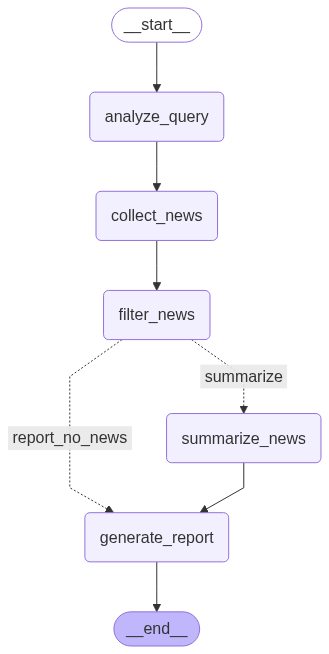

In [28]:
def build_news_workflow():
    """Build the complete news analysis workflow"""
    
    graph_builder = StateGraph(NewsState)
    
    # Add nodes
    graph_builder.add_node("analyze_query", query_analyzer_agent)
    graph_builder.add_node("collect_news", news_collector_agent)
    graph_builder.add_node("filter_news", news_filter_agent)
    graph_builder.add_node("summarize_news", summary_agent)
    graph_builder.add_node("generate_report", report_writer_agent)
    
    # Add edges
    graph_builder.add_edge(START, "analyze_query")
    graph_builder.add_edge("analyze_query", "collect_news")
    graph_builder.add_edge("collect_news", "filter_news")
    
    # Conditional edges
    graph_builder.add_conditional_edges(
        "filter_news",
        should_continue_to_summary,
        {
            "summarize": "summarize_news",
            "report_no_news": "generate_report"
        }
    )
    
    graph_builder.add_edge("summarize_news", "generate_report")
    graph_builder.add_edge("generate_report", END)
    
    # Compile graph with memory
    memory = MemorySaver()
    graph = graph_builder.compile(checkpointer=memory)
    
    return graph

# Build the workflow
news_workflow = build_news_workflow()

# Display workflow diagram
display(Image(news_workflow.get_graph().draw_mermaid_png()))

### Define Enhanced Chat Interface 



## Demo and Test Functions 

### Enhanced Demo Function Definition 


**Primary Function**

- Automated Demo System: Executes comprehensive news analysis demos with professional HTML report generation
- Batch Processing: Handles multiple predefined queries sequentially with error handling
- File Management: Creates organized directory structure and saves reports with timestamped names

**Demo Configuration**

- Test Queries: Three predefined topics covering AI breakthroughs, climate change, and electric vehicle trends
- Report Directory: Creates demo_reports/ folder for organized output storage
- Thread Management: Generates unique thread IDs for each demo session

**Processing Workflow**

- State Initialization: Sets up initial NewsState with empty arrays and default values
- Async Processing: Uses news_workflow.ainvoke() to execute the complete news analysis pipeline
- Error Handling: Wraps each query in try-catch blocks to prevent demo failure
- Status Tracking: Monitors processing status and collects detailed results

**File Generation**

- HTML Reports: Saves complete A4-ready HTML reports for each processed query
- Filename Safety: Sanitizes query text for safe filename generation
- Timestamp Integration: Adds timestamps to prevent filename conflicts
- UTF-8 Encoding: Ensures proper character encoding for international content

**Results Collection**

- Comprehensive Metrics: Tracks query, file location, processing status, and article counts
- Source Analysis: Identifies and lists unique news sources used
- Keyword Extraction: Captures search keywords used in analysis
- Error Logging: Records failed queries with error messages

**Demo Summary Features**

- Success Statistics: Reports successful vs. failed query processing
- Detailed Report List: Shows file locations, article counts, and source information
- Sample Preview: Displays metadata from the first generated report
- Print Instructions: Provides guidance for A4 printing from browser
- File Validation: Checks for Chart.js integration and print-ready CSS

**Output Information**

- Real-time Progress: Console updates during processing with emojis and status indicators
- File Locations: Complete paths to generated HTML reports
- Performance Metrics: Character counts and processing completion status
- User Guidance: Instructions for viewing and printing the generated reports





In [29]:
# ===== ENHANCED DEMO EXECUTION =====

async def enhanced_demo():
    """
    Enhanced demo that generates professional HTML reports
    """
    
    print("=== ENHANCED NEWS SUMMARIZER DEMO ===")
    print("Generating professional A4-ready HTML reports...\n")
    
    # Test queries
    demo_queries = [
        "artificial intelligence breakthrough 2024",
        "climate change latest developments",
        "electric vehicle market trends"
    ]
    
    # Create reports directory
    reports_dir = "demo_reports"
    if not os.path.exists(reports_dir):
        os.makedirs(reports_dir)
    
    results = []
    
    for i, query in enumerate(demo_queries, 1):
        print(f"--- Demo {i}/3: Processing '{query}' ---")
        
        try:
            # Prepare initial state
            initial_state = {
                "query": query,
                "search_keywords": [],
                "news_sources": [],
                "raw_news_articles": [],
                "relevant_articles": [],
                "filtered_articles": [],
                "summary": "",
                "final_report": "",
                "has_news": False,
                "processing_status": "initialized",
                "error_message": None,
                "messages": []
            }
            
            # Generate unique thread ID
            thread_id = f"demo_{i}_{datetime.now().strftime('%H%M%S')}"
            config = {"configurable": {"thread_id": thread_id}}
            
            # Process the query with enhanced workflow
            print(f"🔍 Analyzing: {query}")
            result = await news_workflow.ainvoke(initial_state, config=config)
            
            # Generate filename
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            safe_query = "".join(c for c in query if c.isalnum() or c in (' ', '-', '_'))
            safe_query = safe_query.replace(' ', '_')[:50]
            
            html_filename = f"{reports_dir}/demo_report_{i}_{safe_query}_{timestamp}.html"
            
            # Save HTML report
            with open(html_filename, 'w', encoding='utf-8') as f:
                f.write(result["final_report"])
            
            # Collect results
            results.append({
                "query": query,
                "html_file": html_filename,
                "status": result["processing_status"],
                "has_news": result["has_news"],
                "articles_found": len(result.get("relevant_articles", [])),
                "keywords": result.get("search_keywords", []),
                "sources": list(set([a.get('source', '').upper() for a in result.get('filtered_articles', [])]))
            })
            
            print(f"✅ Status: {result['processing_status']}")
            print(f"📊 Articles found: {len(result.get('relevant_articles', []))}")
            print(f"🏷️ Keywords: {', '.join(result.get('search_keywords', []))}")
            print(f"📰 Sources: {', '.join(list(set([a.get('source', '').upper() for a in result.get('filtered_articles', [])])))}")
            print(f"💾 HTML Report saved: {html_filename}")
            print(f"📏 Report size: {len(result['final_report'])} characters\n")
            
        except Exception as e:
            print(f"❌ Error processing '{query}': {str(e)}\n")
            results.append({
                "query": query,
                "error": str(e),
                "status": "failed"
            })
    
    # Generate demo summary
    print("=== DEMO SUMMARY ===")
    successful_reports = [r for r in results if r.get("status") != "failed"]
    
    print(f"📊 Total reports generated: {len(successful_reports)}/{len(demo_queries)}")
    print(f"📁 Reports saved in: {reports_dir}/")
    print("\n📋 Report Details:")
    
    for i, result in enumerate(successful_reports, 1):
        print(f"\n{i}. Query: {result['query']}")
        print(f"   📄 File: {result['html_file']}")
        print(f"   📊 Articles: {result['articles_found']}")
        print(f"   🏷️ Keywords: {', '.join(result['keywords'])}")
        print(f"   📰 Sources: {', '.join(result['sources'])}")
    
    if successful_reports:
        print(f"\n🎉 Demo complete! Open any HTML file in your browser to view the A4-ready reports.")
        print(f"💡 For printing: Use your browser's print function with A4 paper size.")
        
        # Show sample of first report
        if successful_reports:
            sample_file = successful_reports[0]['html_file']
            print(f"\n📖 Sample report preview ({sample_file}):")
            try:
                with open(sample_file, 'r', encoding='utf-8') as f:
                    content = f.read()
                    # Extract title from HTML
                    title_start = content.find('<title>') + 7
                    title_end = content.find('</title>')
                    if title_start > 6 and title_end > title_start:
                        title = content[title_start:title_end]
                        print(f"   Title: {title}")
                    print(f"   Size: {len(content):,} characters")
                    print(f"   Contains charts: {'chart.js' in content}")
                    print(f"   Print-ready: {'@page' in content}")
            except Exception as e:
                print(f"   Could not preview: {str(e)}")
    
    return results

## Main Driver Code 

In [30]:
# Main execution function
async def run_enhanced_demo():
    """
    Run the complete enhanced demo
    """
    print("🚀 STARTING ENHANCED NEWS SUMMARIZER DEMO")
    print("=" * 60)
    
    # Run enhanced demo
    await enhanced_demo()
    
    print("\n" + "=" * 60)
    
   
    
    print("\n" + "=" * 60)
    print("🎊 ALL DEMOS COMPLETE!")
    print("\nWhat was generated:")
    print("📁 demo_reports/ - Individual demo reports")
    print("📁 news_reports/ - Chat interface reports") 
    print("📁 batch_demo_reports/ - Batch processing reports")
    print("\n💡 Open any HTML file in a web browser to view A4-ready reports!")



In [32]:
# Execute the enhanced demo
if __name__ == "__main__":
    import asyncio
    asyncio.run(run_enhanced_demo())

🚀 STARTING ENHANCED NEWS SUMMARIZER DEMO
=== ENHANCED NEWS SUMMARIZER DEMO ===
Generating professional A4-ready HTML reports...

--- Demo 1/3: Processing 'artificial intelligence breakthrough 2024' ---
🔍 Analyzing: artificial intelligence breakthrough 2024
Error collecting from cnn: Page.goto: Timeout 30000ms exceeded.
Call log:
  - navigating to "https://www.cnn.com/", waiting until "load"

✅ Status: report_completed
📊 Articles found: 1
🏷️ Keywords: artificial intelligence, breakthrough, 2024
📰 Sources: BBC
💾 HTML Report saved: demo_reports/demo_report_1_artificial_intelligence_breakthrough_2024_20250718_011104.html
📏 Report size: 19672 characters

--- Demo 2/3: Processing 'climate change latest developments' ---
🔍 Analyzing: climate change latest developments
Error collecting from cnn: Page.goto: Timeout 30000ms exceeded.
Call log:
  - navigating to "https://www.cnn.com/", waiting until "load"

✅ Status: report_completed
📊 Articles found: 1
🏷️ Keywords: climate, change, latest, devel